In [3]:
import h5py
import numpy as np
import os
import random
import warnings
import joblib
import sys
sys.path.append('..')
sys.path.append('/home/jtc440/dev/l3embedding/src/scikit-image')
sys.path.append('/beegfs/jtc440/miniconda3/envs/l3embedding-new/lib/python3.6/site-packages')
from data.avc.sample import get_max_abs_sample_value, write_to_h5
from data.utils import read_csv_as_dicts
import soundfile as sf
from IPython.display import Audio
import matplotlib.pyplot as plt
%matplotlib inline

/beegfs/jtc440/miniconda3/envs/l3embedding-new/lib/python3.6/site-packages/skvideo/__init__.py:306: UserWarning: ffmpeg/ffprobe not found in path: 
  warnings.warn("ffmpeg/ffprobe not found in path: " + str(path), UserWarning)
/beegfs/jtc440/miniconda3/envs/l3embedding-new/lib/python3.6/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)


In [2]:
PASS_THRU_KEYS = [
 'audio_file',
 'audio_start_sample_idx',
 'label',
 'video',
 'video_bounding_box_start_x',
 'video_bounding_box_start_y',
 'video_brightness_delta',
 'video_file',
 'video_horizontal_flip',
 'video_saturation_factor',
 'video_start_frame_idx'
]

In [3]:
def sample_one_second(audio_data, sampling_frequency, start, augment=False):
    """Return one second audio samples randomly

    Args:
        audio_data: audio data to sample from
        sampling_frequency: audio sample rate
        augment: if True, perturb the data in some fashion

    Returns:
        One second samples, start time, and augmentation parameters

    """
    sampling_frequency = int(sampling_frequency)
    orig_audio_data = audio_data
    audio_data = audio_data[start:start+sampling_frequency]

    if audio_data.shape[0] != sampling_frequency:
        # Pad audio that isn't one second
        warnings.warn('Got audio that is less than one second', UserWarning)
        audio_data = np.pad(audio_data,
                                ((0, sampling_frequency - audio_data.shape[0]),),
                                mode='constant')

    if augment:
        orig_dtype = audio_data.dtype
        audio_data = audio_data.astype(float)
        # Make sure we don't clip
        if np.abs(audio_data).max():
            max_gain = min(0.1, get_max_abs_sample_value(orig_dtype)/np.abs(audio_data).max() - 1)
        else:
            warnings.warn('Got audio sample with all zeros', UserWarning)
            max_gain = 0.1
        gain = 1 + random.uniform(-0.1, max_gain)
        assert 0.9 <= gain <= 1.1
        audio_data *= gain

        audio_data = audio_data.astype(orig_dtype)
        audio_aug_params = {'gain': gain}
    else:
        audio_aug_params = {}

    return audio_data, audio_aug_params

In [8]:
def sample_batch(batch):
    idx = np.random.randint(len(batch['label']))
    plt.imshow(np.array(batch['video'][idx]))
    print("Saturation Factor: {}".format(batch['video_saturation_factor'][idx]))
    print("Brightness Delta: {}".format(batch['video_brightness_delta'][idx]))
    print("Flip: {}".format(batch['video_horizontal_flip'][idx]))
    
    print("Audio Gain: {}".format(batch['audio_gain'][idx]))
    print("Match: {}".format(batch['label'][idx][1]))
    return Audio(np.array(batch['audio'][idx]), rate=48000)
    

In [3]:
subset_path = '/home/jtc440/dev/audioset_filtered_valid.csv'

In [4]:
fname_to_path = {os.path.basename(x['audio_filepath']): x['audio_filepath'] for x in read_csv_as_dicts(subset_path)}

NameError: name 'read_csv_as_dicts' is not defined

In [47]:
! cp /beegfs/work/AudioSetSamples/music_valid/10_10_8.h5 /home/jtc440/dev/l3embedding/10_10_8.h5

In [4]:
batch_path = '/home/jtc440/dev/l3embedding/10_10_9.h5'

In [49]:
blob = h5py.File(batch_path, 'r+')

In [50]:
0.9 <= np.array(blob['audio_gain']).min() <= np.array(blob['audio_gain']).max() <= 1.1

False

In [52]:
audio_files = [x.decode('utf8') for x in blob['audio_file']]
audio_start_sample_indices = [int(x) for x in blob['audio_start_sample_idx']]

In [53]:
audio = []
audio_gain = []
for fname, start_idx in zip(audio_files, audio_start_sample_indices):
    audio_path = fname_to_path[fname]
    audio_data, sampling_frequency = sf.read(audio_path,
                                             dtype='int16',
                                             always_2d=True)
    audio_data = audio_data.mean(axis=-1).astype('int16')
    audio_data, aug_params = sample_one_second(audio_data, 48000, start_idx, augment=True)
    audio.append(audio_data)
    audio_gain.append(aug_params['gain'])

/beegfs/jtc440/miniconda3/envs/l3embedding-new/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Got audio sample with all zeros


In [54]:
blob['audio_gain'].shape

(1024,)

In [55]:
blob['audio'][:,:,:] = np.ascontiguousarray(np.vstack(audio)[:,None,:])
blob['audio_gain'][:] = np.array(audio_gain)

In [56]:
blob.close()

In [17]:
blob = h5py.File(batch_path, 'r')


In [18]:
0.9 <= np.array(blob['audio_gain']).min() <= np.array(blob['audio_gain']).max() <= 1.1

True

Saturation Factor: 0.9093165993690491
Brightness Delta: -0.04653353616595268
Flip: True
Audio Gain: 1.0007603128834794
Match: 1


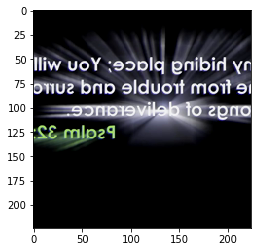

In [43]:
sample_batch(blob)

In [51]:
blob.close()

In [25]:
def process_subset(subset_batch_dir, subset_path, n_jobs=1, verbose=0):
    fname_to_path = {os.path.basename(x['audio_filepath']): x['audio_filepath'] for x in read_csv_as_dicts(subset_path)}
    joblib.Parallel(n_jobs=n_jobs, verbose=verbose)(
        process_batch(os.path.join(subset_batch_dir, fname), fname_to_path) \
        for fname in os.listdir(subset_batch_dir)[:50]) # <---- TESTING

In [26]:
def process_batch(batch_path, fname_to_path):
    with h5py.File(batch_path, 'r+') as blob:
        audio_files = [x.decode('utf8') for x in blob['audio_file']]
        audio_start_sample_indices = [int(x) for x in blob['audio_start_sample_idx']]

        audio = []
        audio_gain = []
        for fname, start_idx in zip(audio_files, audio_start_sample_indices):
            audio_path = fname_to_path[fname]
            audio_data, sampling_frequency = sf.read(audio_path,
                                                     dtype='int16',
                                                     always_2d=True)
            audio_data = audio_data.mean(axis=-1).astype('int16')
            audio_data, aug_params = sample_one_second(audio_data, 48000, start_idx, augment=True)
            audio.append(audio_data)
            gain = aug_params['gain']

            if not (0.9 <= gain <= 1.1):
                err_msg = "File {} in batch {} has invalid audio gain {}"
                raise ValueError(err_msg.format(audio_path, batch_path, gain))

            audio_gain.append(gain)

        blob['audio'][:,:,:] = np.ascontiguousarray(np.vstack(audio)[:,None,:])
        blob['audio_gain'][:] = np.array(audio_gain)

In [27]:
#process_subset('/beegfs/work/AudioSetSamples/music_train', '/home/jtc440/dev/audioset_filtered_train.csv')
process_subset('/beegfs/work/AudioSetSamples/music_valid', '/home/jtc440/dev/audioset_filtered_valid.csv', n_jobs=2, verbose=50)
#process_subset('/beegfs/work/AudioSetSamples/music_test', '/home/jtc440/dev/audioset_filtered_test.csv')

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


/beegfs/jtc440/miniconda3/envs/l3embedding-new/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Got audio sample with all zeros


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   41.3s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1540s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Batch computation too fast (0.1540s.) Setting batch_size=4.
[Parallel(n_jobs=2)]: Done   2 tasks      | elapsed:  4.2min


/beegfs/jtc440/miniconda3/envs/l3embedding-new/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:686: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: 